In [2]:
import numpy as np
import torch
from Encoder import Encoder
from feature_extractors import AlexNet, AlexNetConv5, AlexNetConv1
from tqdm import tqdm
from utils import listdir, image_to_tensor,word2sense, Subject, stack_features
from scipy import spatial

import os

#LOC_conv5 = torch.load('saved_encoders/EVC_conv1_subj001.pth', map_location=lambda storage, loc: storage)

#print(LOC_conv5)

In [ ]:
a1 = np.load('predicted/subj001/EVC_conv1/aardvark/aardvark.npy')
#z1 = np.load('predicted/subj001/EVC_conv1/zebra/zebra.npy')
#a4 = np.load('predicted/subj004/LOC_conv1/aardvark/aardvark.npy')
#z4 = np.load('predicted/subj004/LOC_conv1/zebra/zebra.npy')

In [ ]:
#print('Things voxel predictions: \n')
print('s1 (aardvark): ', len(a1[:20]))
#print('s4 (aardvark): ', a4[:20])
#print('s1 (zebra): ', z1[:20])
#print('s4 (zebra): ', z4[:20])

In [ ]:

encoder = torch.load(os.path.join('saved_encoders', 'LOC_conv1_subj004' + '.pth'),
                     map_location=lambda storage, loc: storage)

In [ ]:
scaffold = np.load('saved_weights/FFA_fc6_subj001.npy')
print(scaffold.shape)

fmri_mean = np.mean(scaffold, axis=0)
fmri_cov = np.cov(scaffold, rowvar=False)
print(fmri_mean.shape)
print(fmri_cov.shape)

weight = np.random.multivariate_normal(fmri_mean, fmri_cov, (scaffold.shape[0]))
print(weight.shape)

In [ ]:
w2s_file = "ThingsWrd2Sns.txt"
word_list, w2s_embeddings = word2sense(w2s_file)
nDim = 2250

layers = ['conv1', 'conv5', 'fc6']

for l in layers:
    feat_extractor = AlexNet(pretrained=False, layer=layer)
    predictions = {}
    stimuli_folder_path = os.path.join(os.getcwd(), 'images/')
    for c in tqdm(conditions, total=len(conditions)):
        if c.split('/')[-1] in word_list:
            #print(c.split('/')[-1])
            stimuli_path = [os.path.join(stimuli_folder_path, c, s) for s in listdir(os.path.join(stimuli_folder_path, c))]
            for s in stimuli_path:
                if ".DS_Store" in s:
                    stimuli_path.remove(s)
            #print(stimuli_path)
            stimuli = [image_to_tensor(s, resolution=256) for s in stimuli_path]
            stimuli = torch.stack(stimuli)
            
            with torch.no_grad():
                print(feat_extractor(stimuli))
                preds = feat_extractor(stimuli).mean(dim=0).cpu().numpy()
            predictions[c] = preds

    print(len(predictions))
    torch.save(predictions, os.path.join('features_' + layer + '.pth'))

In [ ]:


feat_extractor = AlexNet(pretrained=False, layer='fc6')
predictions = {}
stimuli_folder_path = os.path.join(os.getcwd(), 'images/')
for c in tqdm(conditions, total=len(conditions)):
    stimuli_path = [os.path.join(stimuli_folder_path, c, s) for s in listdir(os.path.join(stimuli_folder_path, c))]
    for s in stimuli_path:
        if ".DS_Store" in s:
            stimuli_path.remove(s)
    #print(stimuli_path)
    stimuli = [image_to_tensor(s, resolution=256) for s in stimuli_path]
    stimuli = torch.stack(stimuli)
    with torch.no_grad():
        preds = feat_extractor(stimuli).mean(dim=0).cpu().numpy()
    #print(preds.shape)
    predictions[c] = preds

torch.save(predictions, os.path.join('features_fc6_r' + '.pth'))

In [ ]:
w2s_file = "ThingsWrd2Sns.txt"
word_list, w2s_embeddings = word2sense(w2s_file)
nDim = 2250

feat_extractor = AlexNetConv1()
predictions = {}
stimuli_folder_path = os.path.join(os.getcwd(), 'images/')
for c in tqdm(word_list, total=len(word_list)):
    stimuli_path = [os.path.join(stimuli_folder_path, c, s) for s in listdir(os.path.join(stimuli_folder_path, c))]
    for s in stimuli_path:
        if ".DS_Store" in s:
            stimuli_path.remove(s)

        #print(stimuli_path)
    stimuli = [image_to_tensor(s, resolution=256) for s in stimuli_path]
    stimuli = torch.stack(stimuli)
    with torch.no_grad():
        preds = feat_extractor(stimuli).mean(dim=0).cpu().numpy()
        #print(preds.shape)
    predictions[c] = preds

torch.save(predictions, os.path.join('features_conv1' + '.pth'))

In [ ]:
print(len(predictions))

In [ ]:
features_conv5 = torch.load('features_conv5.pth')

In [ ]:
features_conv5 = torch.load('features_conv5.pth')

In [ ]:
print(features_conv5['aardvark'].shape)

In [3]:
embedding_file = "sensevec_augmented_with_wordvec.csv"
f = open(embedding_file, 'r', encoding='utf-8')
senseveclines = f.readlines()
f.close()

embedding_file = "wordvec.csv"
f = open(embedding_file, 'r', encoding='utf-8')
wordveclines = f.readlines()
f.close()

embedding_file = "ThingsWrd2Vec_subset.txt"
f = open(embedding_file, 'r', encoding='utf-8')
wordvec2lines = f.readlines()
f.close()


w2s_file = "ThingsWrd2Sns.txt"
_, w2s_embeddings = word2sense(w2s_file)



#print(w2s_embeddings)

wordvec = {}
sensevec = {}
wordvec2 = {}

things = sorted(os.listdir('predicted_EVC_conv5'))
nanlist = []
nanlist_sv = []
for i, thing in enumerate(things):
    if thing in w2s_embeddings:
        if i < 10:
            print(i, thing, senseveclines[i].split(',')[0])
        wordvec[thing] = wordveclines[i].split(',')
        wordvec[thing][-1] = wordvec[thing][-1].replace('\n', '')
        sensevec[thing] = senseveclines[i].split(',')
        sensevec[thing][-1] = sensevec[thing][-1].replace('\n', '')

        if 'NaN' in wordvec[thing]:
            nanlist.append(i)
            
        if 'NaN' in sensevec[thing]:
            nanlist_sv.append(i)
        
#print([embedding[0] for i, embedding in enumerate(sensevec.values()) if i < 10])
#print(w2s_embeddings['aardvark'])

# Wordvec filtered by CM
for i, wv2 in enumerate(wordvec2lines):
    if i == 0:
        continue
    word = (wordvec2lines[i].split(','))[0]
    if word in w2s_embeddings:
        wordvec2[word] = wordvec2lines[i].split(',')[1:]
        wordvec2[word][-1] = wordvec2[word][-1].replace('\n', '')

for wv in wordvec2:
    wordvec2[wv] = np.array(wordvec2[wv]).astype(np.float)

# Sensevec filtered to 312 categories
sensevec_filtered = {}

for i, wv2 in enumerate(wordvec2lines):
    if i == 0:
        continue
    word =  (wordvec2lines[i].split(','))[0]
    if word in sensevec.keys():
        sensevec_filtered[word] = sensevec[word]

# Wordvec (osf) filtered to 312 categories
wordvec_filtered = {}

for i, wv2 in enumerate(wordvec2lines):
    if i == 0:
        continue
    word =  (wordvec2lines[i].split(','))[0]
    if word in wordvec.keys():
        wordvec_filtered[word] = wordvec[word]

0 aardvark 0.0025181295781300
1 abacus 0.0567918972040000
2 accordion 0.0272048586844000
3 acorn 0.0340743570020000
4 airbag 0.0015223497280100
5 airboat 0.0185316571884000
6 airplane 0.0259030562690000
7 album 0.1006937218170000
8 alligator 0.0105041589904998
9 almond 0.0764623456676000


In [90]:
print(spatial.distance.cosine(np.array(sensevec['airplane']).astype('float64'), \
                      np.array(sensevec['ambulance']).astype('float64')))

print(spatial.distance.cosine(np.array(sensevec['airplane']).astype('float64'), \
                              np.array(sensevec['apple']).astype('float64')))


print(spatial.distance.cosine(np.array(sensevec['apple']).astype('float64'), \
                              np.array(sensevec['avocado']).astype('float64')))

print(spatial.distance.cosine(np.array(sensevec['ant']).astype('float64'), \
                              np.array(sensevec['bee']).astype('float64')))

print(spatial.distance.cosine(np.array(wordvec['airplane']).astype('float64'), \
                      np.array(wordvec['ambulance']).astype('float64')))

print(spatial.distance.cosine(np.array(wordvec['airplane']).astype('float64'), \
                              np.array(wordvec['apple']).astype('float64')))

print(spatial.distance.cosine(np.array(wordvec['apple']).astype('float64'), \
                              np.array(wordvec['avocado']).astype('float64')))

print(spatial.distance.cosine(np.array(wordvec['ant']).astype('float64'), \
                              np.array(wordvec['bee']).astype('float64')))

print(spatial.distance.cosine(np.array(wordvec['computer']).astype('float64'), \
                              np.array(wordvec['aardvark']).astype('float64')))

print(spatial.distance.cosine(np.array(wordvec['apple']).astype('float64'), \
                              np.array(wordvec['bee']).astype('float64')))

print(spatial.distance.cosine(np.array(w2s_embeddings['airplane']).astype('float64'), \
                              np.array(w2s_embeddings['ambulance']).astype('float64')))


print(spatial.distance.cosine(np.array(w2s_embeddings['airplane']).astype('float64'), \
                              np.array(w2s_embeddings['apple']).astype('float64')))


print(spatial.distance.cosine(np.array(w2s_embeddings['apple']).astype('float64'), \
                              np.array(w2s_embeddings['avocado']).astype('float64')))



print(spatial.distance.cosine(np.array(sensevec['apple']).astype('float64'), \
                              np.array(sensevec['bee']).astype('float64')))

print(spatial.distance.cosine(np.array(w2s_embeddings['apple']).astype('float64'), \
                              np.array(w2s_embeddings['bee']).astype('float64')))


print(spatial.distance.cosine(np.array(sensevec['car']).astype('float64'), \
                              np.array(sensevec['bee']).astype('float64')))

print(spatial.distance.cosine(np.array(wordvec['car']).astype('float64'), \
                              np.array(wordvec['bee']).astype('float64')))


print(spatial.distance.cosine(np.array(w2s_embeddings['car']).astype('float64'), \
                              np.array(w2s_embeddings['bee']).astype('float64')))


target = w2s_embeddings['airplane']
A = [embedding for i, embedding in enumerate(w2s_embeddings.values()) if embedding != target]
tree = spatial.KDTree(A)
key_list = list(w2s_embeddings.keys())
val_list = list(w2s_embeddings.values())
closest = tree.query(np.array(w2s_embeddings['airplane']))
print(closest)
print(things[closest[1]])

0.7609542210997366
0.8486483642411846
0.7404701468870902
0.8234512056154194
nan
nan
0.8877170510014428
0.9431595987499748
0.9341285939928726
0.8043475787778472
0.916595121225272
0.9982060791593481
0.741949910790787
0.6150404062428321
0.9992308568347793
0.8014033116358646
0.8606506561870603
0.9993142128172737
(0.17857574413702013, 111)
blender


In [3]:
target_items = ['airplane', 'banana', 'ant', 'bookshelf']

for item in target_items:
    print(item)
    target = w2s_embeddings[item]
    A = [embedding for i, embedding in enumerate(w2s_embeddings.values()) if embedding != target]
    
    tree = spatial.KDTree(A)
    key_list = list(w2s_embeddings.keys())
    val_list = list(w2s_embeddings.values())
    closest = tree.query(np.array(w2s_embeddings[item]))
    print(closest)
    print(things[closest[1]])
    


airplane
(0.17857574413702013, 111)
blender
banana
(0.17356913099574192, 771)
mandolin
ant
(0.19477327105713446, 1418)
washboard
bookshelf
(0.19067654881018162, 135)
book


In [49]:
tree = spatial.KDTree(A[:10])

In [24]:
target_items = ['car', 'banana', 'ant', 'bookshelf']


for item in target_items:
    print(item)
    ç = w2s_embeddings[item]
    A = [np.array([np.float32(t) for t in embedding]) for i, embedding in enumerate(wordvec.values()) if embedding != target]
    A = np.stack(A)
    tree = spatial.KDTree(A)
    key_list = list(wordvec.keys())
    val_list = list(wordvec.values())
    closest = tree.query(np.array(wordvec[item]))
    print(closest)
    print(things[closest[1]])
    
for item in target_items:
    print(item)
    target = w2s_embeddings[item]
    A = np.array([embedding for i, embedding in enumerate(sensevec.values()) if embedding != target]).astype(np.float)
    tree = spatial.KDTree(A)
    key_list = list(sensevec.keys())
    val_list = list(sensevec.values())
    closest = tree.query(np.array(sensevec[item]))
    print(closest)
    print(things[closest[1]])

car


ValueError: Troublesome data array: [-0.03808594  0.24316406  0.04516602 ...  0.36328125 -0.02355957
 -0.11279297]

In [153]:
from sklearn.decomposition import PCA
from collections import OrderedDict 
from sklearn.impute import SimpleImputer

nPC = 300
pca = PCA(n_components=nPC)

w2s_stacked = np.stack([condition_embedding for condition, condition_embedding \
                        in OrderedDict(w2s_embeddings).items()])
wordvec_stacked = np.stack([condition_embedding for condition, condition_embedding \
                        in OrderedDict(wordvec).items()])

sensevec_stacked = np.stack([condition_embedding for condition, condition_embedding \
                        in OrderedDict(sensevec).items()])

wordvec2_stacked = np.stack([condition_embedding for condition, condition_embedding \
                        in OrderedDict(wordvec2).items()])
wordvec_filtered_stacked = np.stack([condition_embedding for condition, condition_embedding \
                        in OrderedDict(wordvec_filtered).items()])
sensevec_filtered_stacked = np.stack([condition_embedding for condition, condition_embedding \
                        in OrderedDict(sensevec_filtered).items()])


pca.fit(w2s_stacked)
w2s_pc = pca.explained_variance_ratio_.cumsum()
w2s_stacked_reduced = pca.transform(w2s_stacked)

#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp_mean.fit(wordvec_stacked.astype('float64'))
#wordvec_stacked = imp_mean.transform(wordvec_stacked.astype('float64'))

pca.fit(wordvec_stacked)
wordvec_pc = pca.explained_variance_ratio_.cumsum()
w2s_stacked_reduced = pca.transform(wordvec_stacked)

#imp_mean.fit(sensevec_stacked.astype('float64'))
#sensevec_stacked = imp_mean.transform(sensevec_stacked.astype('float64'))
pca.fit(sensevec_stacked)
sensevec_pc = pca.explained_variance_ratio_.cumsum()
w2s_stacked_reduced = pca.transform(sensevec_stacked)



[3.75233152e-03 2.67344228e-03 1.95050354e-03 1.84293796e-03
 1.75424464e-03 1.63190066e-03 1.59247102e-03 1.48080836e-03
 1.30835917e-03 1.24670783e-03 1.17884776e-03 1.05962369e-03
 1.04728101e-03 1.00529152e-03 9.84441698e-04 9.66889397e-04
 9.54492227e-04 9.49466321e-04 9.37092840e-04 9.17563582e-04
 8.67580878e-04 8.59152018e-04 8.50695490e-04 8.36300034e-04
 8.22919239e-04 7.85660719e-04 7.68240842e-04 7.58135253e-04
 7.38591207e-04 7.23803470e-04 7.05771473e-04 6.98056015e-04
 6.84357404e-04 6.61011492e-04 6.56550078e-04 6.35427297e-04
 6.15650127e-04 6.01978976e-04 5.84177624e-04 5.76153134e-04
 5.63906894e-04 5.56944837e-04 5.50536867e-04 5.46728782e-04
 5.43601656e-04 5.38882815e-04 5.30297391e-04 5.22862435e-04
 5.14324703e-04 5.11810678e-04 5.08948361e-04 5.01645253e-04
 5.01268591e-04 4.94937880e-04 4.89162029e-04 4.84326531e-04
 4.81420066e-04 4.74769836e-04 4.65990516e-04 4.61091529e-04
 4.56684735e-04 4.53998084e-04 4.47486149e-04 4.46159667e-04
 4.31637332e-04 4.247179

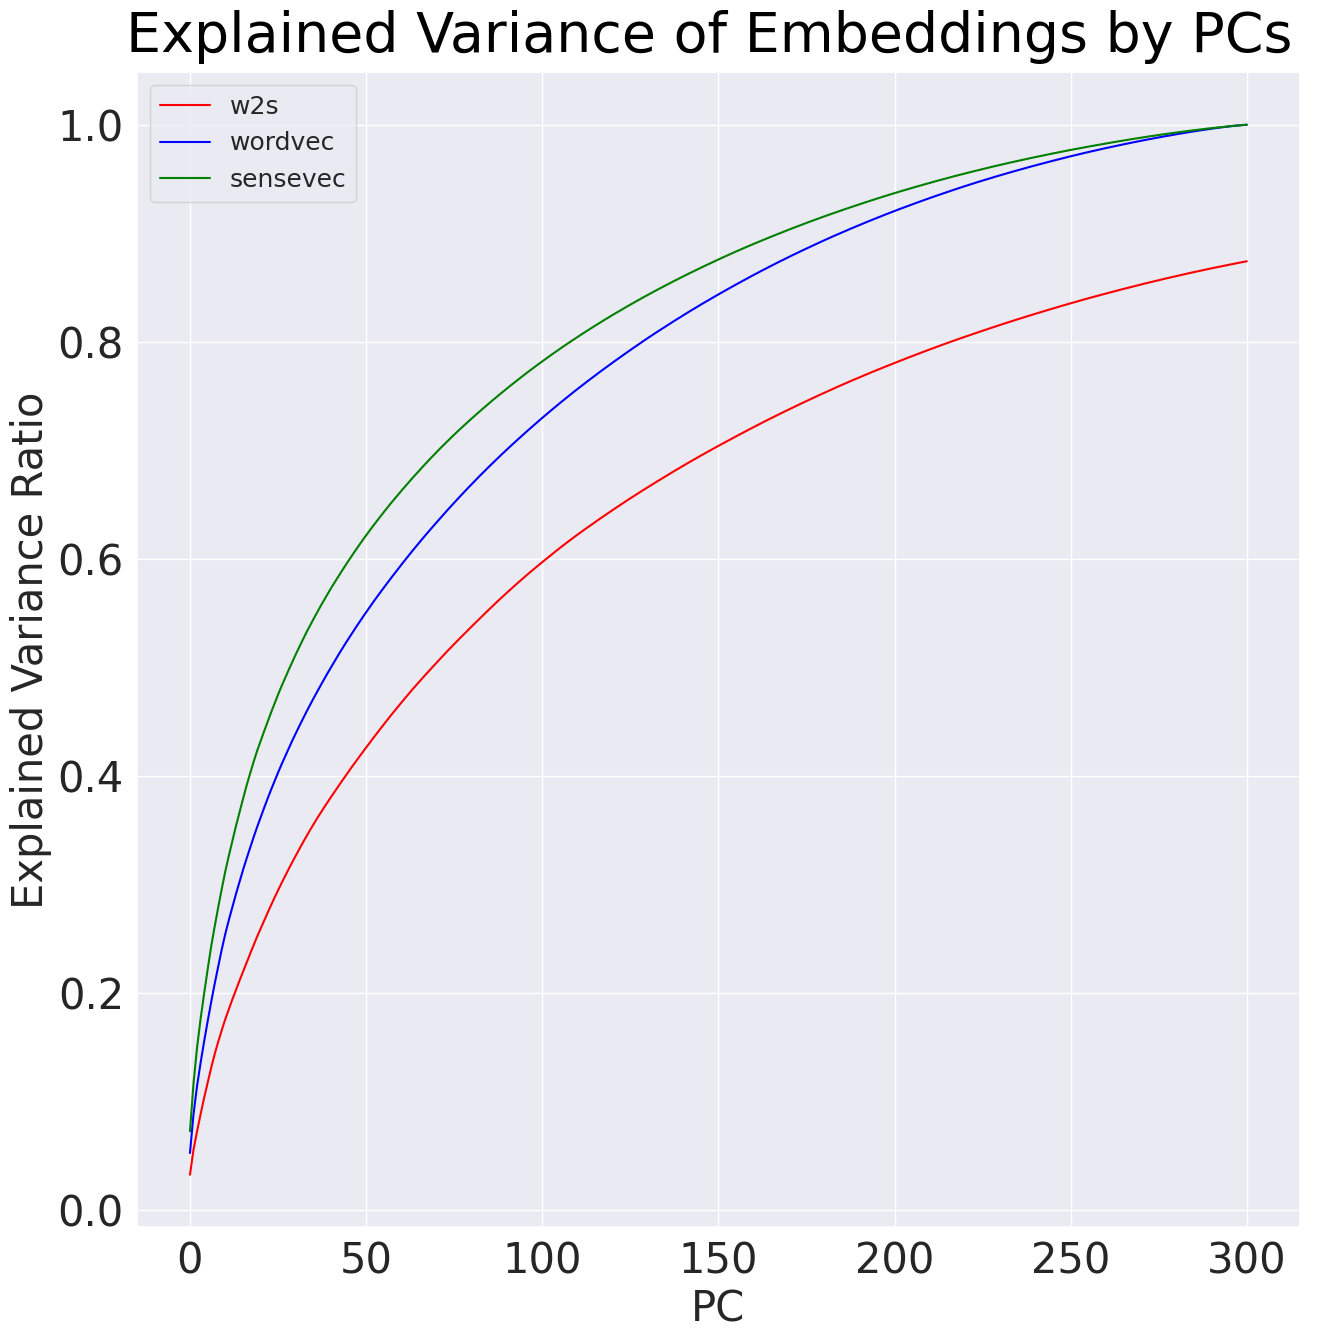

In [152]:

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

x = np.linspace(0, nPC, nPC)
plt.figure(figsize=(15,15))

title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'30'}
sns.set()

ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(30)
plt.xlabel('PC', **axis_font)
plt.ylabel('Explained Variance Ratio', **axis_font)
plt.title("Explained Variance of Embeddings by PCs ", **title_font)

plt.plot(x, w2s_pc, '-', color='red', label='w2s')
plt.plot(x, wordvec_pc, '-', color='blue', label='wordvec')
plt.plot(x, sensevec_pc, '-', color='green', label='sensevec')
#plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
#plt.plot(x, roi_dim_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

plt.legend(prop={'size': 18});

#plt.savefig('figures0923/SemanticDimensionality_face_' + layer + '.png')
sns.reset_defaults()

In [126]:
c1 = "0.83520687 0.06736944 0.03908521 0.02514903 0.00919782 0.0075388 0.0048608 0.00314457 0.00241045 0.00124402".split(' ')
c2 = "0.8132473 0.06972375 0.04707978 0.02782445 0.01122485 0.00871911 0.00586764 0.00402012 0.00364375 0.0019371".split(' ')
c3 = "0.9404497 0.02671301 0.00839618 0.00659645 0.00465797 0.00220781 0.0018123 0.00147163 0.00108212 0.00102215".split(' ')
c4 = "0.9397096 0.02037254 0.01208286 0.00868724 0.00404004 0.00261602 0.00177539 0.00161365 0.00131979 0.00107878".split(' ')

f1 = "0.5865926 0.24389903 0.05955742 0.0381332 0.01583304 0.01262605 0.00930256 0.00795881 0.00496856 0.00369741".split(' ')
f2 = "0.60676885 0.2090701 0.05675361 0.04011622 0.01916492 0.01429796 0.01117649 0.00881363 0.00665458 0.00541373".split(' ')
f3 = "0.69763607 0.10548506 0.05513639 0.03549683 0.0250407 0.01524476 0.01066779 0.01015368 0.00676929 0.00553646".split(' ')
f4 = "0.65393305 0.12174808 0.06106401 0.03600384 0.02718733 0.01705899 0.01522039 0.01151679 0.00867729 0.00621073".split(' ')

explained_var = []
explained_var_cumsum = []

rois = ['LOC', 'PPA', 'FFA', 'EVC']
nPC = 50
pca = PCA(n_components=nPC)
for roi in rois:
    for s in range(1, 5):
        subject = Subject(s, [roi])
        dict_object2vec = subject.condition_voxels

        if s == 1:
            voxels_object2vec = np.stack([subject.condition_voxels[c] for c in dict_object2vec])
        else:
            temp = np.stack([subject.condition_voxels[c] for c in dict_object2vec])
            voxels_object2vec = np.hstack((voxels_object2vec, temp))

        print(voxels_object2vec.shape) # (81, 195) (# of samples, # of features)

    pca.fit(voxels_object2vec)   
    voxels_object2vec = pca.transform(voxels_object2vec) # (81, 10)

    print(voxels_object2vec.shape)
    #print(pca.explained_variance_.cumsum())
    print(pca.explained_variance_ratio_.cumsum())
    
    #explained_var.append(pca.explained_variance_.cumsum())
    
    #The percentage of the explained variance is:

    #xplained_variance_ratio_
    #The variance i.e. the eigenvalues of the covariance matrix is:

    #explained_variance_
    #Formula: explained_variance_ratio_ = explained_variance_ / np.sum(explained_variance_)

    explained_var_cumsum.append(pca.explained_variance_ratio_.cumsum())
    


explained_var_cumsum_s1 = []

rois = ['LOC', 'PPA', 'FFA', 'EVC']
nPC = 50
pca = PCA(n_components=nPC)
for roi in rois:
    subject = Subject(1, [roi])
    dict_object2vec = subject.condition_voxels

    voxels_object2vec = np.stack([subject.condition_voxels[c] for c in dict_object2vec])
        
    pca.fit(voxels_object2vec)   
    voxels_object2vec = pca.transform(voxels_object2vec) # (81, 10)

    print(voxels_object2vec.shape)
    #print(pca.explained_variance_.cumsum())
    print(pca.explained_variance_ratio_.cumsum())
    
    explained_var_cumsum_s1.append(pca.explained_variance_ratio_.cumsum())

(81, 195)
(81, 394)
(81, 593)
(81, 793)
(81, 50)
[0.63589644 0.7256976  0.78676105 0.8272474  0.85546833 0.8811188
 0.90297955 0.918784   0.9316763  0.94038993 0.94707197 0.9529214
 0.9581274  0.96293235 0.96661216 0.9700704  0.97331434 0.9761586
 0.9787807  0.9806564  0.98237014 0.9838465  0.985255   0.986456
 0.98751503 0.98847634 0.9893939  0.9902549  0.9910669  0.9917283
 0.99233264 0.9929052  0.9934213  0.99392664 0.9943942  0.99482447
 0.99520177 0.9955571  0.9958888  0.99619025 0.99646497 0.99672765
 0.99696547 0.9971818  0.99736506 0.997547   0.9977168  0.99788207
 0.99802625 0.99816686]
(81, 200)
(81, 400)
(81, 600)
(81, 800)
(81, 50)
[0.64286417 0.7548913  0.8107393  0.84866875 0.8655676  0.8791701
 0.8911652  0.90073067 0.9091386  0.91686785 0.9233112  0.9290666
 0.93423724 0.93911016 0.9436268  0.9478314  0.95134014 0.954796
 0.9580133  0.9608978  0.963709   0.9661089  0.9683377  0.97039914
 0.97220606 0.97395134 0.97559017 0.9770582  0.97847    0.9797387
 0.9808627  0.9819

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]


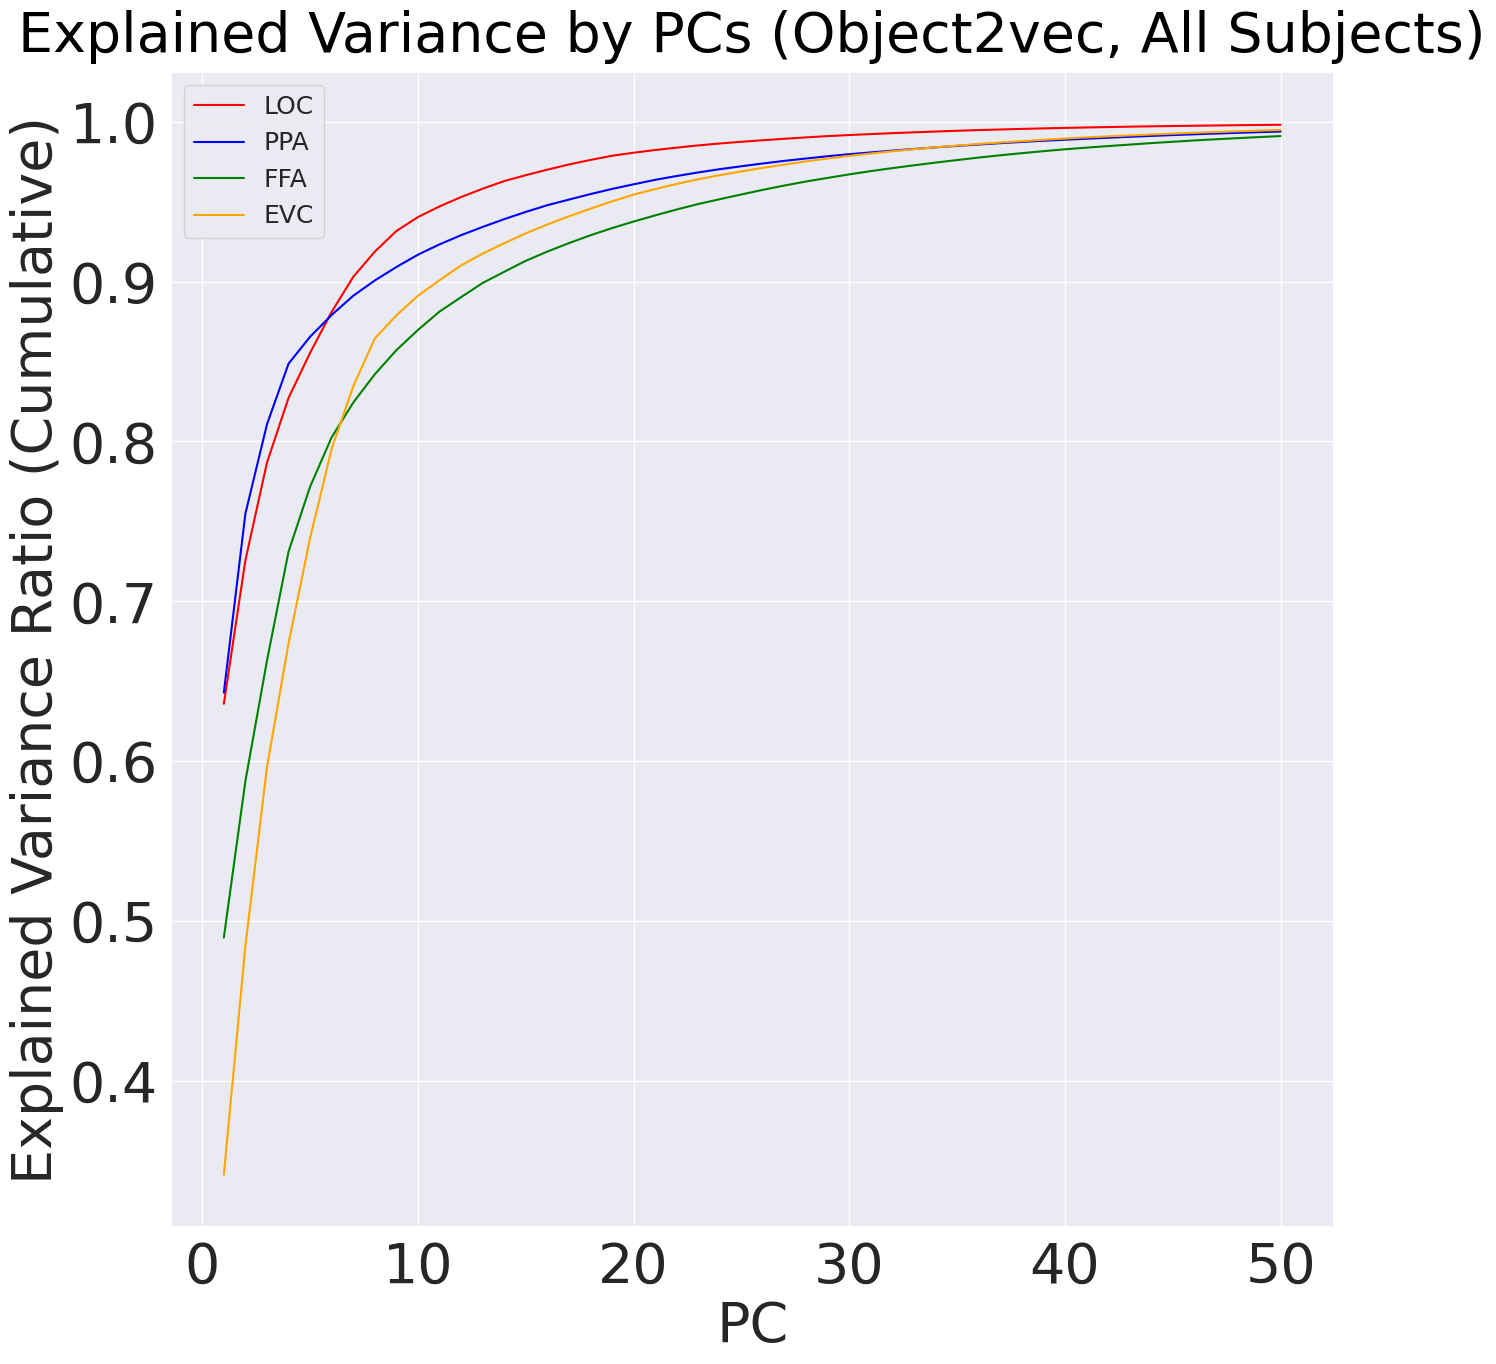

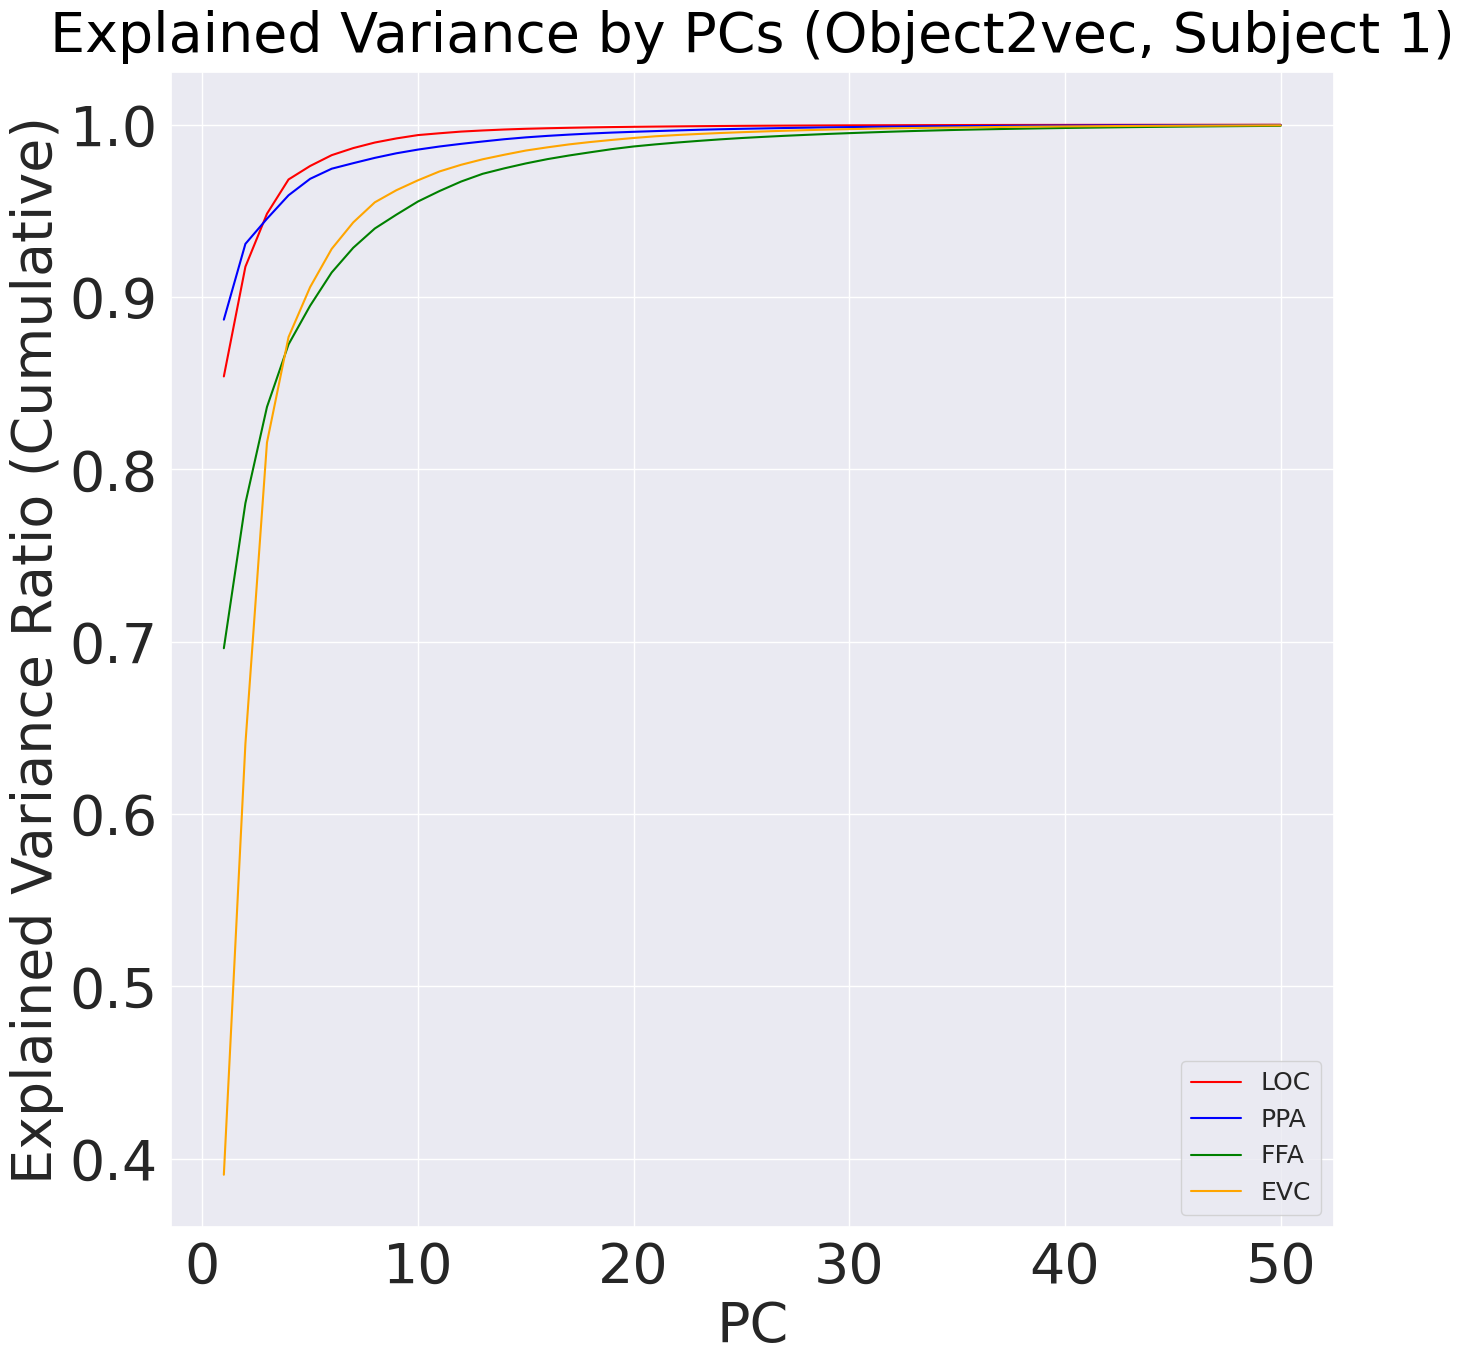

In [139]:
x = np.linspace(1, nPC, nPC)
print(x)
plt.figure(figsize=(15,15))

title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'40'}
sns.set()

ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(40)
plt.xlabel('PC', **axis_font)
plt.ylabel('Explained Variance Ratio (Cumulative)', **axis_font)
plt.title("Explained Variance by PCs (Object2vec, All Subjects)", **title_font)

plt.plot(x, explained_var_cumsum[0], '-', color='red', label='LOC')
plt.plot(x, explained_var_cumsum[1], '-', color='blue', label='PPA')
plt.plot(x, explained_var_cumsum[2], '-', color='green', label='FFA')
plt.plot(x, explained_var_cumsum[3], '-', color='orange', label='EVC')

#plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
#plt.plot(x, roi_dim_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

plt.legend(prop={'size': 18});

#plt.savefig('figures0923/SemanticDimensionality_face_' + layer + '.png')
sns.reset_defaults()


x = np.linspace(1, nPC, nPC)
print(x)
plt.figure(figsize=(15,15))

title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'40'}
sns.set()

ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(40)
plt.xlabel('PC', **axis_font)
plt.ylabel('Explained Variance Ratio (Cumulative)', **axis_font)
plt.title("Explained Variance by PCs (Object2vec, Subject 1)", **title_font)

plt.plot(x, explained_var_cumsum_s1[0], '-', color='red', label='LOC')
plt.plot(x, explained_var_cumsum_s1[1], '-', color='blue', label='PPA')
plt.plot(x, explained_var_cumsum_s1[2], '-', color='green', label='FFA')
plt.plot(x, explained_var_cumsum_s1[3], '-', color='orange', label='EVC')

#plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
#plt.plot(x, roi_dim_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

plt.legend(prop={'size': 18});

#plt.savefig('figures0923/SemanticDimensionality_face_' + layer + '.png')
sns.reset_defaults()

In [143]:
rois = ['LOC', 'PPA', 'FFA', 'EVC'] 
layers = ['conv5', 'fc6'] #'conv1', 'conv5', 'fc6', 'conv1_r', 'conv5_r', 'fc6_r'
subjects = ['subj001/', 'subj002/', 'subj003/', 'subj004/'] #subj001/ , 'subj002/', 'subj003/', 'subj004/'

        
nPC = 50
pca = PCA(n_components=nPC)

voxels_cumsum = []
for layer in layers:
    for roi in rois:
        for sub in subjects:

            fmri_path = "predictedww/" + sub + roi + "_" + layer
            fmri_path = os.path.join(os.getcwd(), fmri_path) 

            if sub == 'subj001/':
                voxels_things = stack_features(fmri_path, fmri=True)
            else:
                temp = stack_features(fmri_path, fmri=True)
                voxels_things = np.hstack((voxels_things, temp))

        print(voxels_things.shape)
        pca.fit(voxels_things)   

        voxels_things = pca.transform(voxels_things)

        print(voxels_things.shape)
        print(pca.explained_variance_ratio_.cumsum())

        voxels_cumsum.append(pca.explained_variance_ratio_.cumsum())

(1470, 793)
(1470, 50)
[0.6163608  0.7427803  0.80925566 0.858804   0.88680416 0.90798277
 0.9269841  0.942989   0.9520504  0.959485   0.9656821  0.9708163
 0.9749119  0.97855675 0.98141545 0.98399496 0.98625857 0.9883534
 0.98985887 0.9909382  0.9919561  0.9927355  0.9934361  0.9940781
 0.99464923 0.99521923 0.99566185 0.9960803  0.9964315  0.99675375
 0.9970347  0.9973126  0.99754626 0.99776036 0.99796194 0.9981403
 0.9983017  0.9984565  0.9986038  0.998733   0.99883944 0.99894243
 0.9990395  0.99912316 0.99919796 0.9992627  0.99932384 0.9993834
 0.9994365  0.9994875 ]
(1470, 800)
(1470, 50)
[0.7413961  0.8595971  0.89566284 0.9179085  0.9339632  0.943517
 0.9506585  0.9573592  0.9622585  0.96702534 0.9706399  0.9738068
 0.976405   0.978656   0.9806829  0.9824921  0.9841984  0.9857457
 0.9871154  0.98847395 0.9894664  0.99036914 0.9912366  0.99190813
 0.9925591  0.9931114  0.99363625 0.9941151  0.9945767  0.9949967
 0.99538    0.9957214  0.9960307  0.99632144 0.99659365 0.99684334
 0

In [140]:
rois = ['LOC', 'PPA', 'FFA', 'EVC'] 
layers = ['conv5', 'fc6'] #'conv1', 'conv5', 'fc6', 'conv1_r', 'conv5_r', 'fc6_r'
subjects = ['subj001', 'subj002', 'subj003', 'subj004'] #subj001/ , 'subj002/', 'subj003/', 'subj004/'

        
nPC = 50
pca = PCA(n_components=nPC)

voxels_random_cumsum = []
for layer in layers:
    for roi in rois:
        for sub in subjects:

            fmri_path = "predictedww/" + sub + '_random/' + roi + "_" + layer
            fmri_path = os.path.join(os.getcwd(), fmri_path) 

            if sub == 'subj001':
                voxels_things = stack_features(fmri_path, fmri=True)
            else:
                temp = stack_features(fmri_path, fmri=True)
                voxels_things = np.hstack((voxels_things, temp))

        print(voxels_things.shape)
        pca.fit(voxels_things)   

        voxels_things = pca.transform(voxels_things)

        print(voxels_things.shape)
        print(pca.explained_variance_ratio_.cumsum())

        voxels_random_cumsum.append(pca.explained_variance_ratio_.cumsum())

(1470, 793)
(1470, 50)
[0.62508472 0.75154715 0.8134179  0.86049476 0.88837343 0.90902536
 0.92824492 0.94287446 0.95215297 0.95946102 0.96575035 0.9712867
 0.97542424 0.97915938 0.98198831 0.98454053 0.98672979 0.98863109
 0.99008682 0.9911914  0.99220886 0.99295185 0.99360443 0.99424764
 0.99481577 0.99535319 0.99579628 0.99618516 0.99650878 0.99681018
 0.99709225 0.99736102 0.99761142 0.99782918 0.99803214 0.99822071
 0.99837788 0.99852669 0.99867013 0.99880106 0.99890552 0.99900524
 0.99909598 0.99917913 0.99924927 0.99931077 0.99936883 0.99942503
 0.99947773 0.99952739]
(1470, 800)
(1470, 50)
[0.7441584  0.86001296 0.89891174 0.9212684  0.93775694 0.9465422
 0.95373042 0.95931308 0.96459852 0.96914808 0.97250342 0.97546199
 0.9778478  0.97999417 0.98203222 0.98382443 0.98540213 0.98680258
 0.98807435 0.98931441 0.99023234 0.99105237 0.99181324 0.9924931
 0.99312083 0.99363883 0.99413093 0.99457119 0.99499327 0.99537077
 0.99574308 0.99605318 0.99635406 0.9966343  0.99689689 0.9971

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]


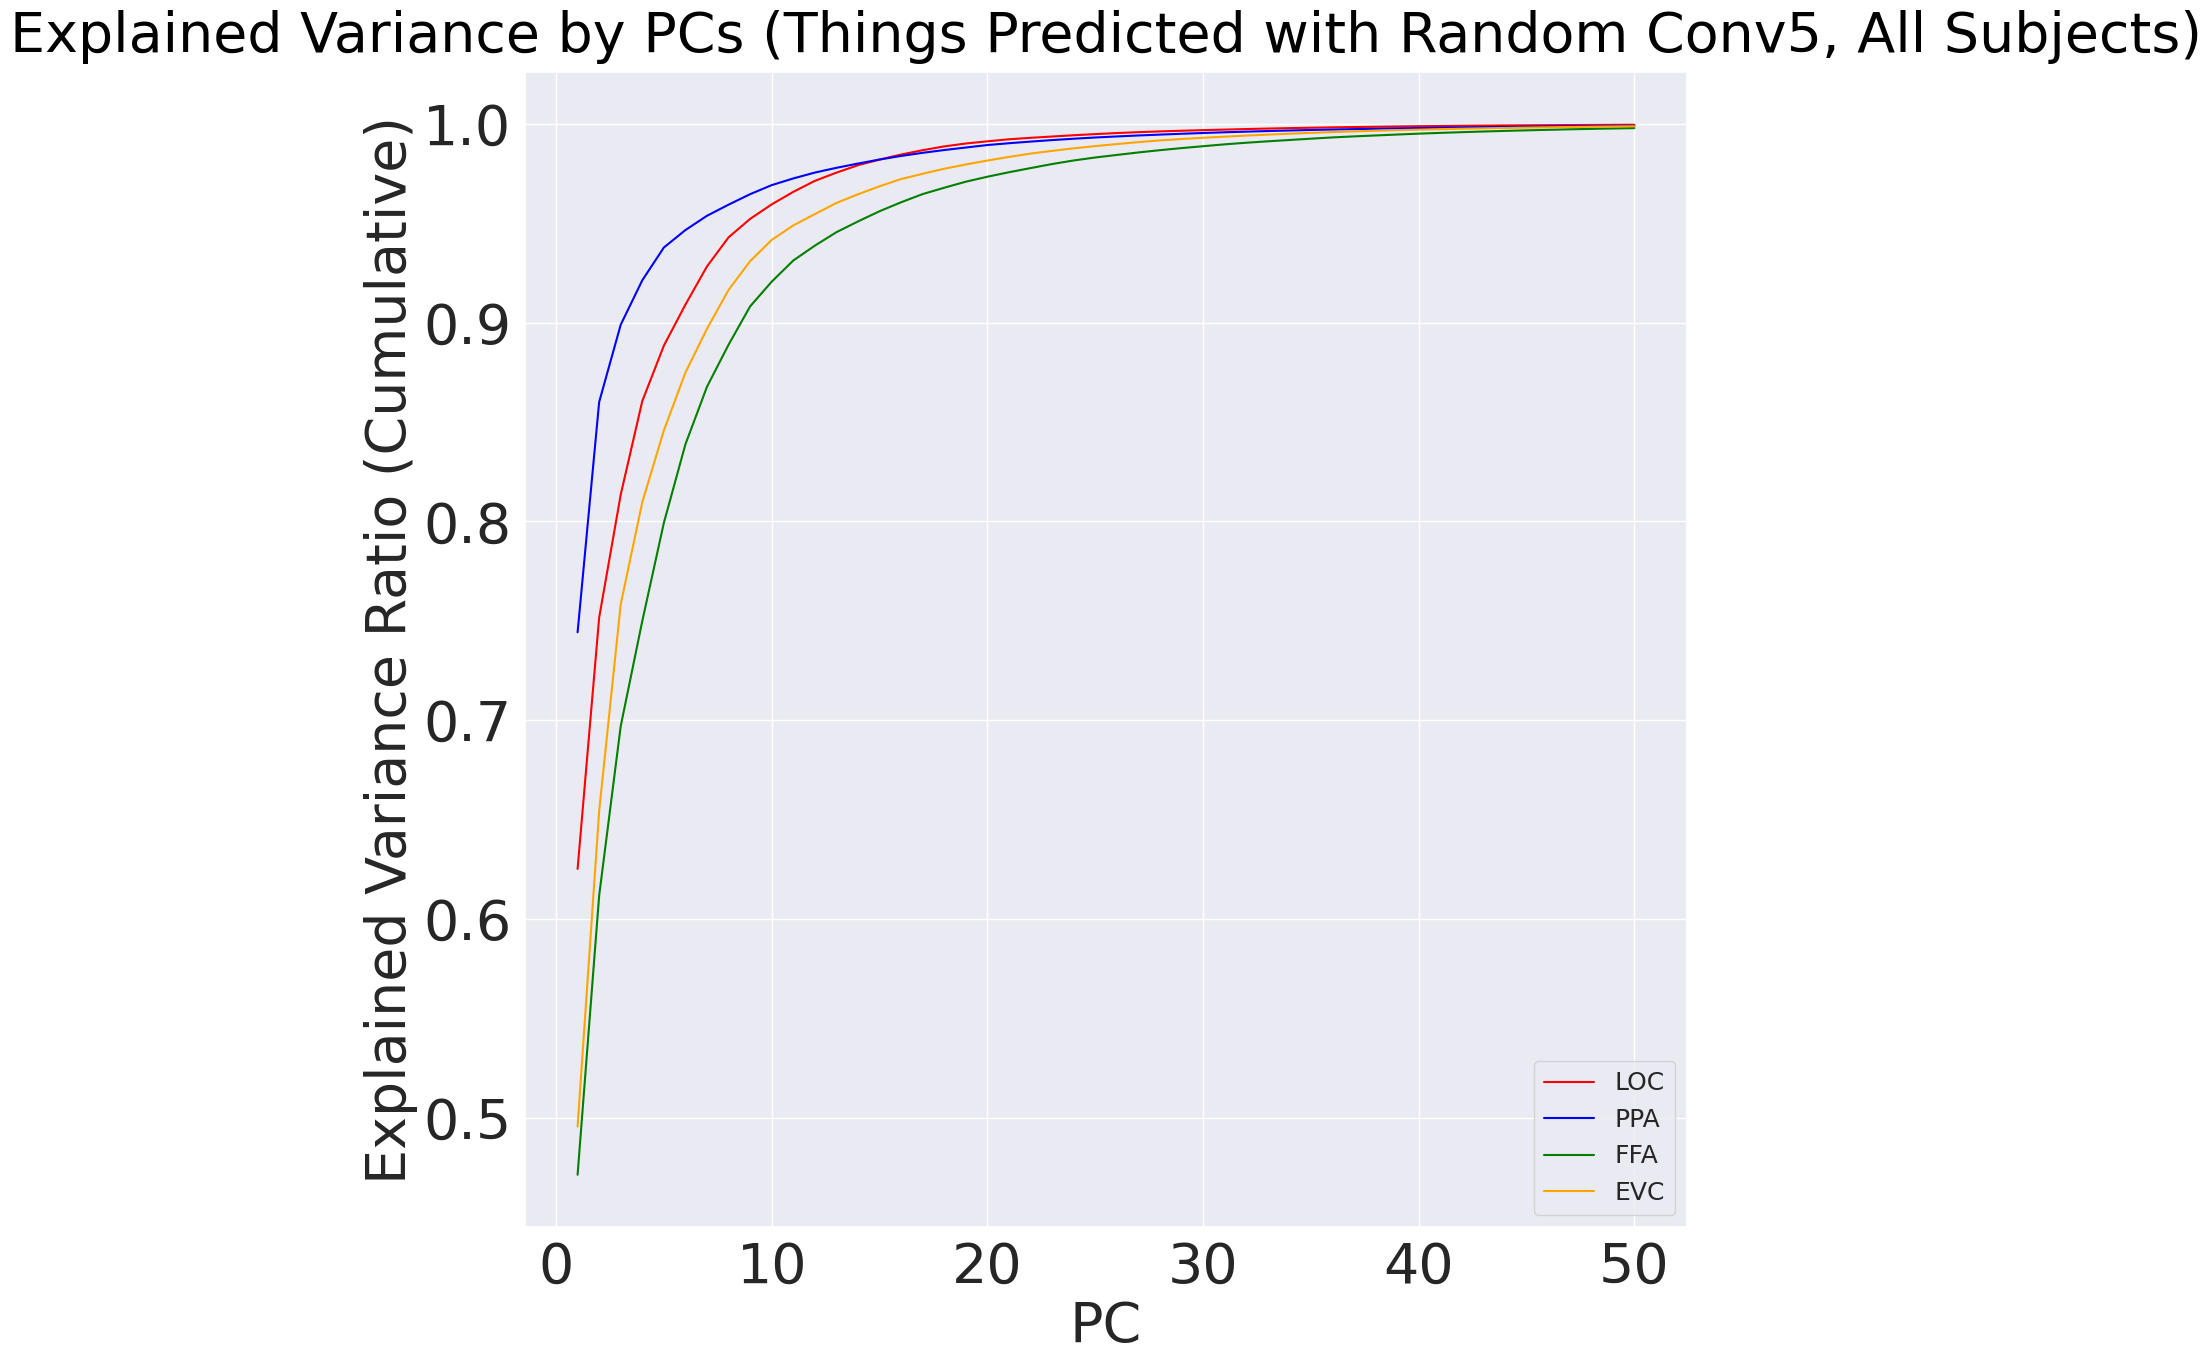

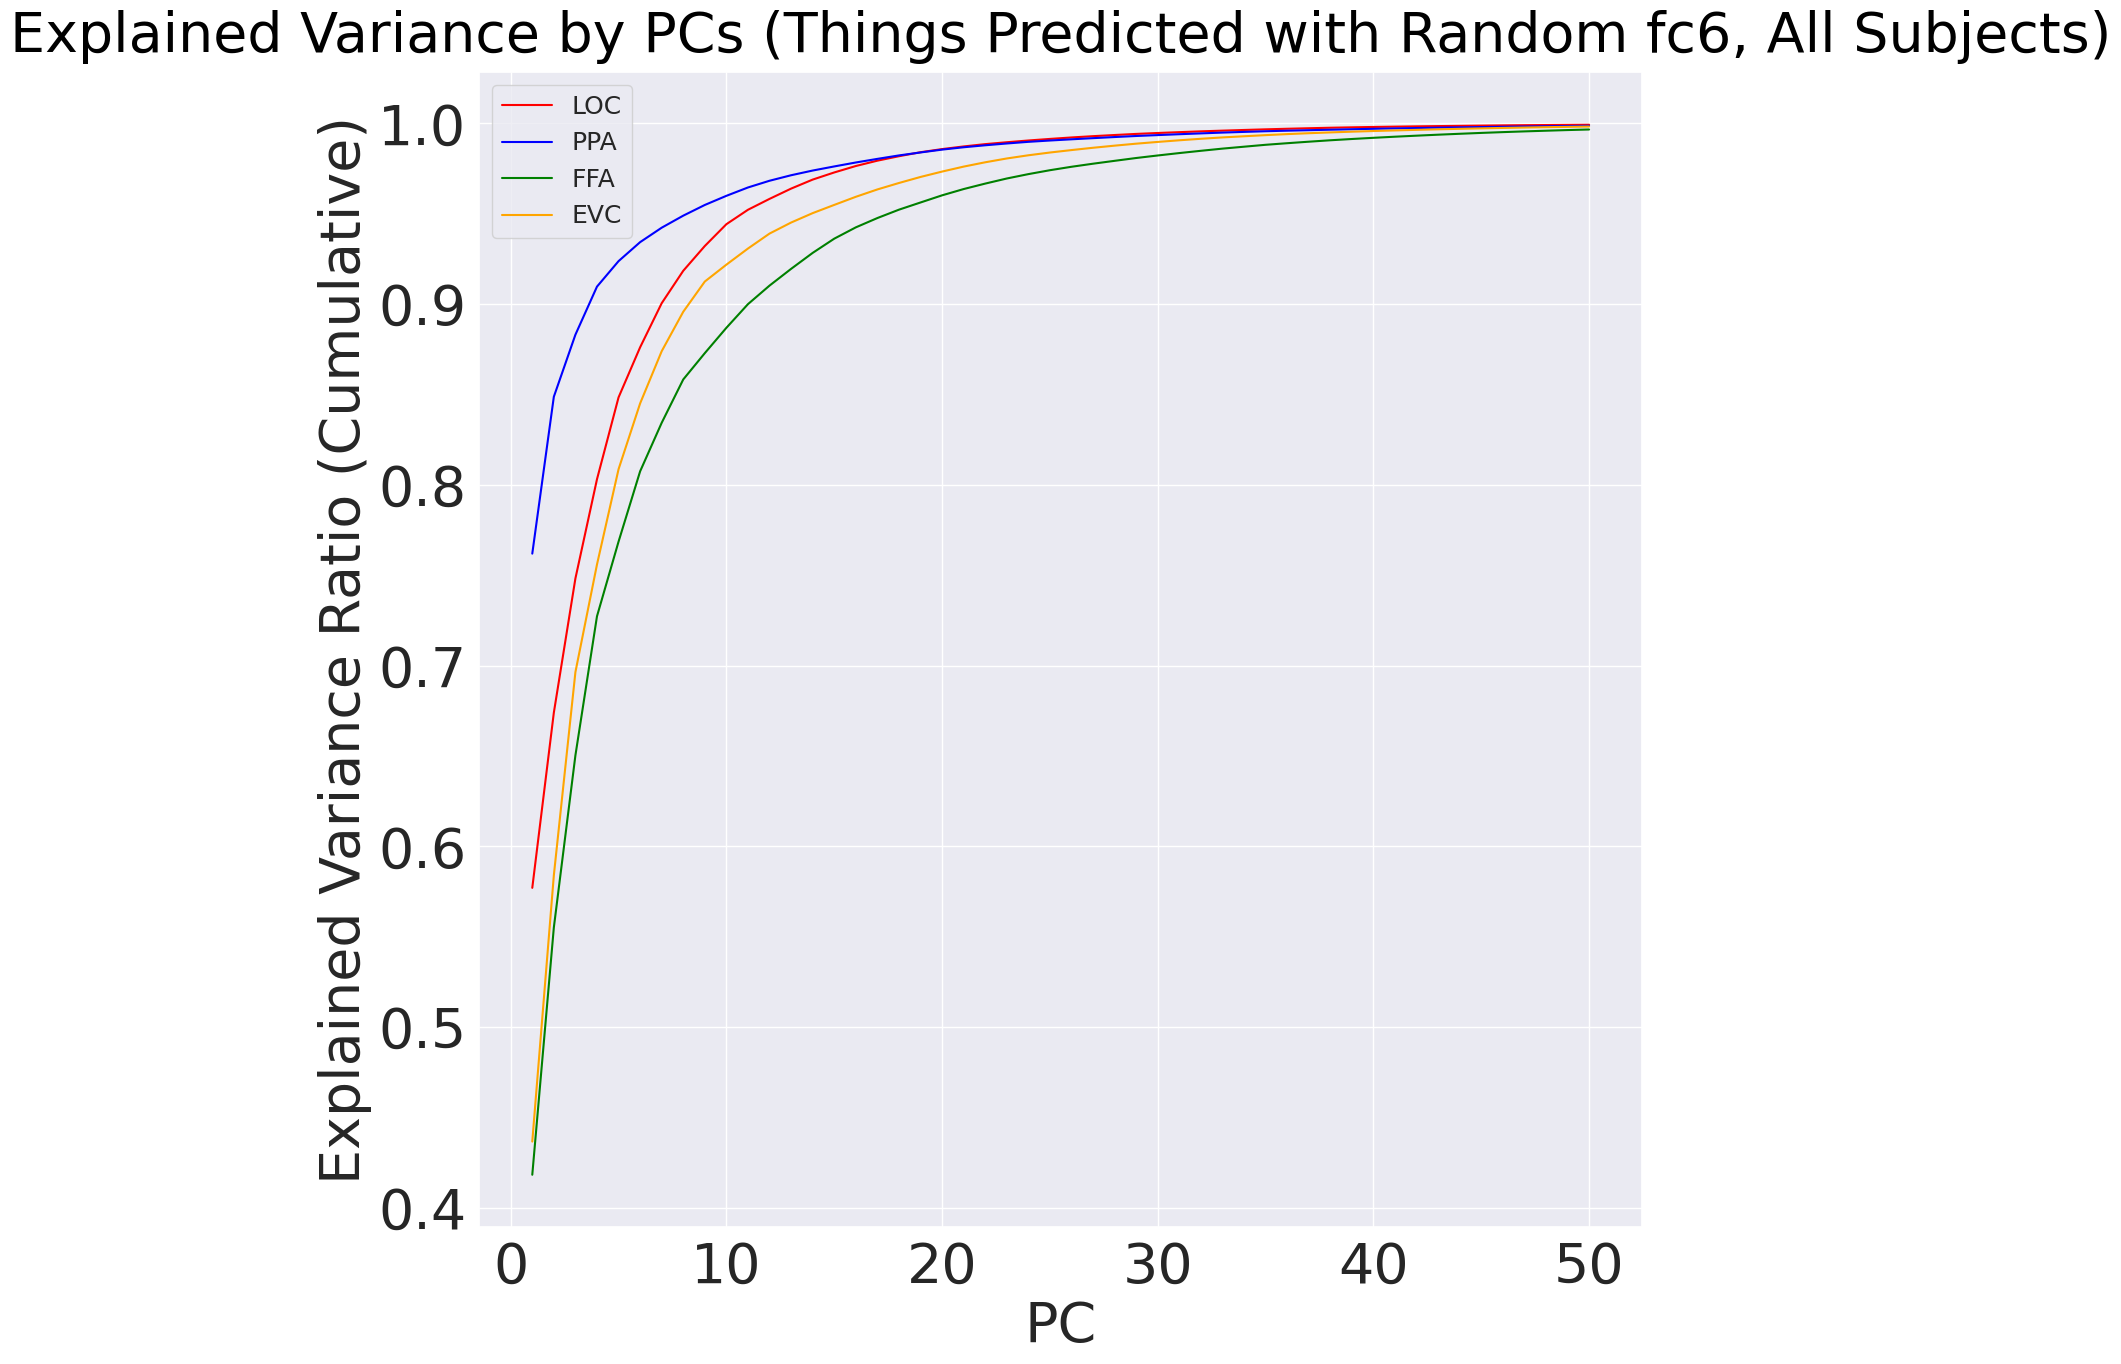

In [142]:
x = np.linspace(1, nPC, nPC)
print(x)
plt.figure(figsize=(15,15))

title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'40'}
sns.set()

ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(40)
plt.xlabel('PC', **axis_font)
plt.ylabel('Explained Variance Ratio (Cumulative)', **axis_font)
plt.title("Explained Variance by PCs (Things Predicted with Random Conv5, All Subjects)", **title_font)

plt.plot(x, voxels_random_cumsum[0], '-', color='red', label='LOC')
plt.plot(x, voxels_random_cumsum[1], '-', color='blue', label='PPA')
plt.plot(x, voxels_random_cumsum[2], '-', color='green', label='FFA')
plt.plot(x, voxels_random_cumsum[3], '-', color='orange', label='EVC')

#plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
#plt.plot(x, roi_dim_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

plt.legend(prop={'size': 18});

#plt.savefig('figures0923/SemanticDimensionality_face_' + layer + '.png')
sns.reset_defaults()


x = np.linspace(1, nPC, nPC)
print(x)
plt.figure(figsize=(15,15))

title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'40'}
sns.set()

ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(40)
plt.xlabel('PC', **axis_font)
plt.ylabel('Explained Variance Ratio (Cumulative)', **axis_font)
plt.title("Explained Variance by PCs (Things Predicted with Random fc6, All Subjects)", **title_font)

plt.plot(x, voxels_random_cumsum[4], '-', color='red', label='LOC')
plt.plot(x, voxels_random_cumsum[5], '-', color='blue', label='PPA')
plt.plot(x, voxels_random_cumsum[6], '-', color='green', label='FFA')
plt.plot(x, voxels_random_cumsum[7], '-', color='orange', label='EVC')

#plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
#plt.plot(x, roi_dim_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

plt.legend(prop={'size': 18});

#plt.savefig('figures0923/SemanticDimensionality_face_' + layer + '.png')
sns.reset_defaults()

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


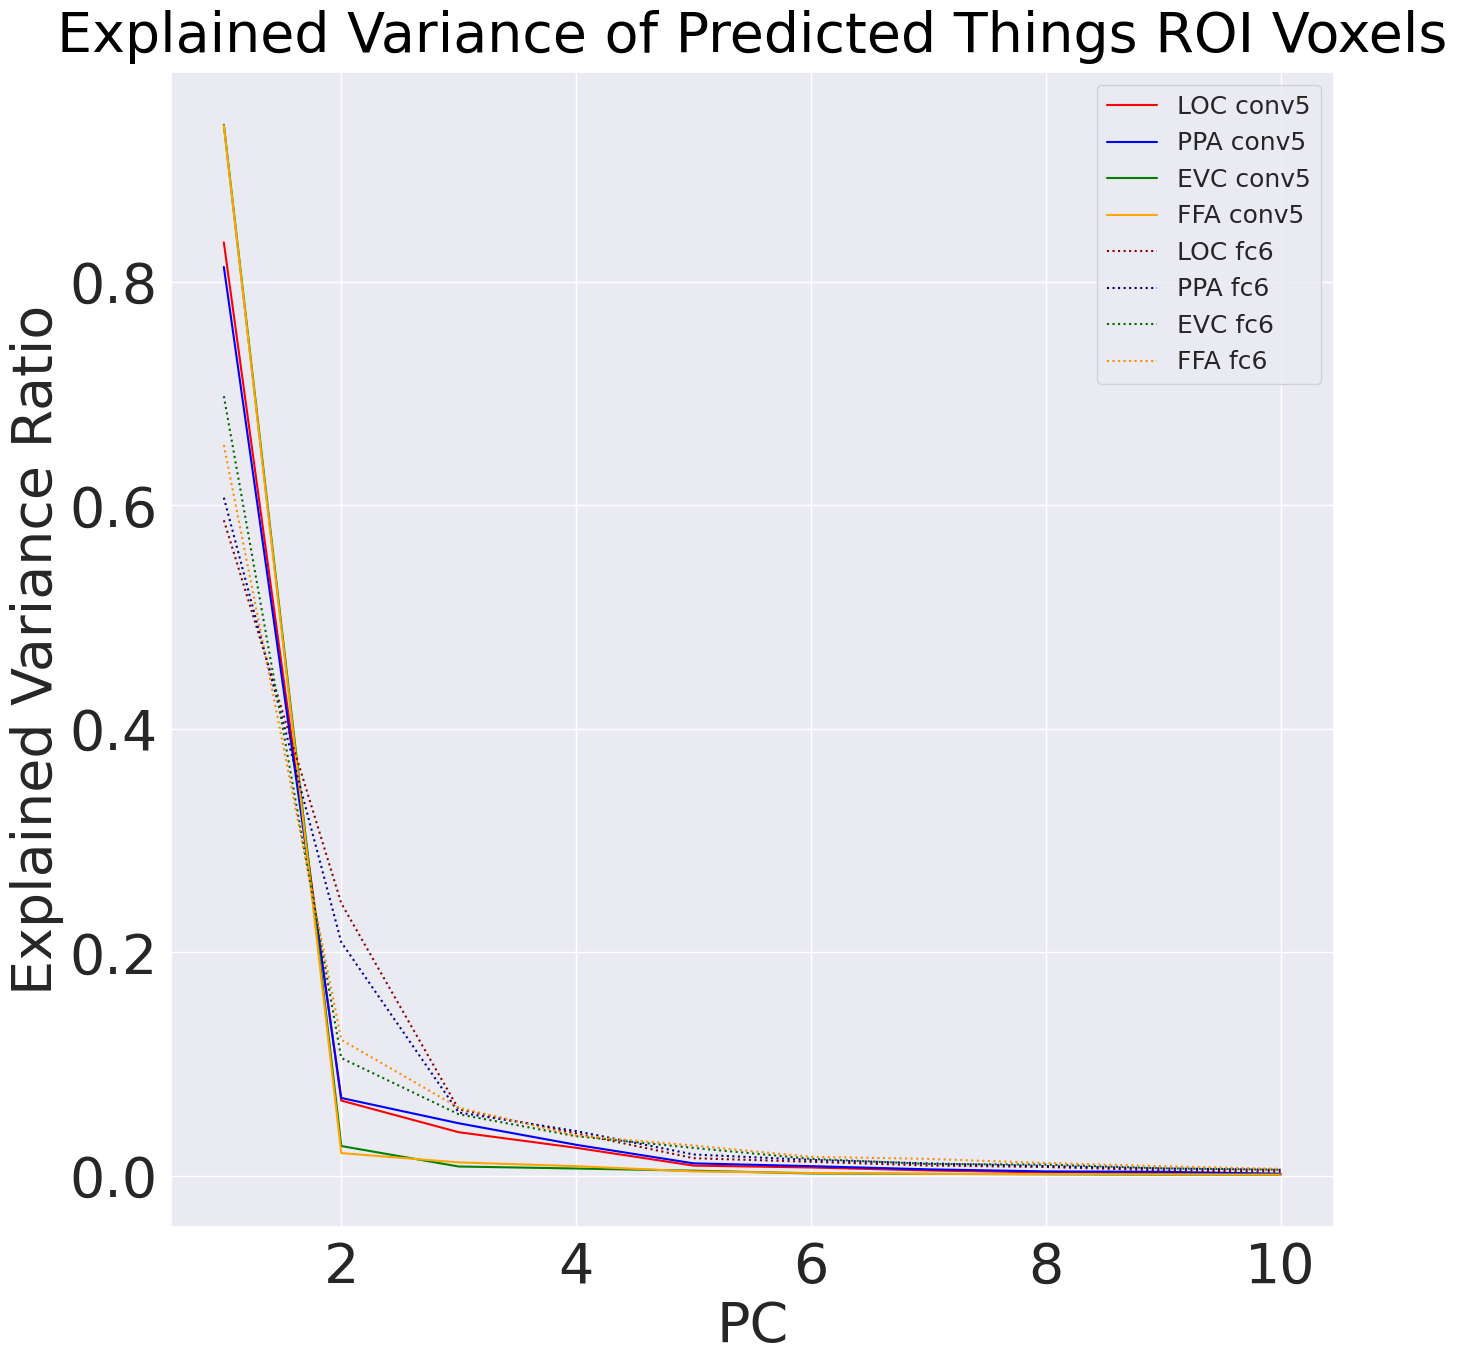

In [83]:
c1 = [float(f) for f in c1]
c2 = [float(f) for f in c2]
c3 = [float(f) for f in c3]
c4 = [float(f) for f in c4]
f1 = [float(f) for f in f1]
f2 = [float(f) for f in f2]
f3 = [float(f) for f in f3]
f4 = [float(f) for f in f4]

x = np.linspace(1, 10, 10)
print(x)
plt.figure(figsize=(15,15))

title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'40'}
sns.set()

ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(40)
plt.xlabel('PC', **axis_font)
plt.ylabel('Explained Variance Ratio', **axis_font)
plt.title("Explained Variance of Predicted Things ROI Voxels", **title_font)

plt.plot(x, c1, '-', color='red', label='LOC conv5')
plt.plot(x, c2, '-', color='blue', label='PPA conv5')
plt.plot(x, c3, '-', color='green', label='EVC conv5')
plt.plot(x, c4, '-', color='orange', label='FFA conv5')

plt.plot(x, f1, ':', color='darkred', label='LOC fc6')
plt.plot(x, f2, ':', color='darkblue', label='PPA fc6')
plt.plot(x, f3, ':', color='darkgreen', label='EVC fc6')
plt.plot(x, f4, ':', color='darkorange', label='FFA fc6')

#plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
#plt.plot(x, roi_dim_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

plt.legend(prop={'size': 18});

#plt.savefig('figures0923/SemanticDimensionality_face_' + layer + '.png')
sns.reset_defaults()

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


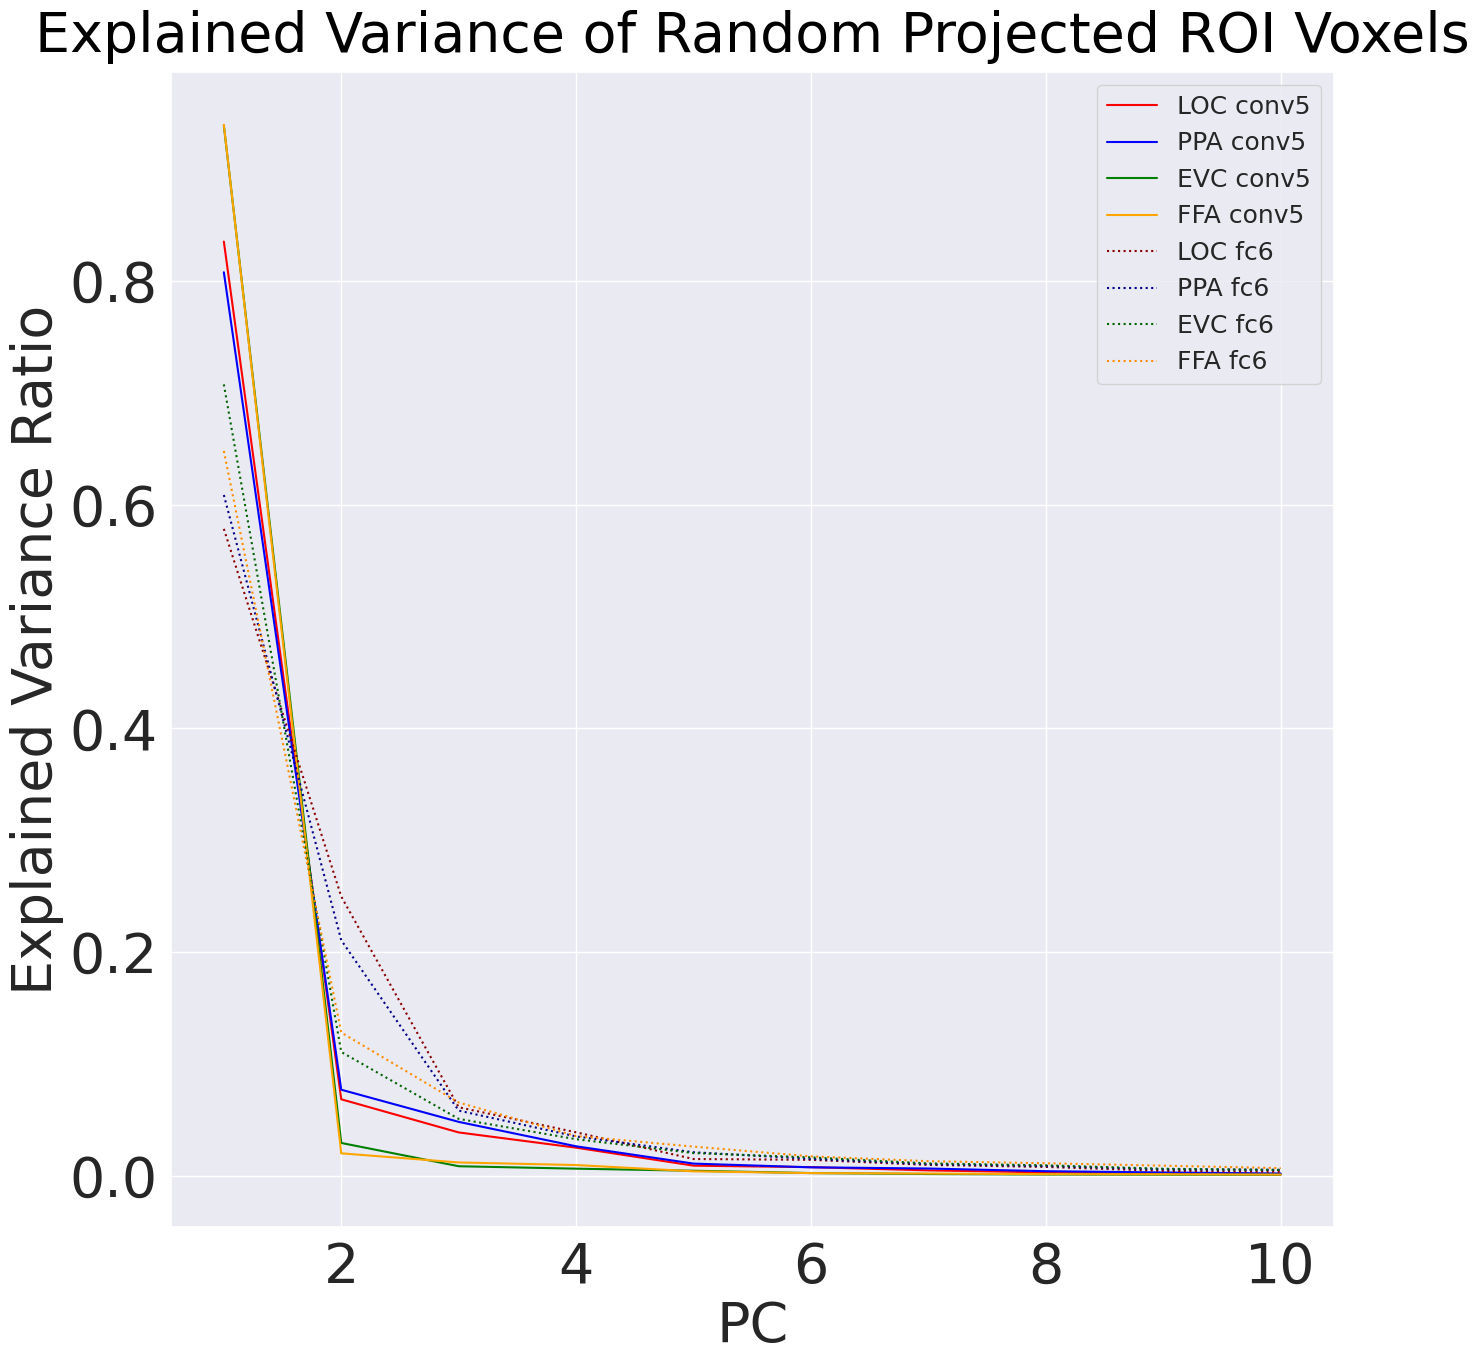

In [81]:
c1 = "0.83517769 0.06840616 0.03877879 0.02515931 0.00907961 0.00774066 0.00485898 0.00311769 0.002001 0.00130321".split(' ')
c2 = "0.80775226 0.07696186 0.04821906 0.02638362 0.0109172 0.00759136 0.00651511 0.00412448 0.00299139 0.00206591".split(' ')
c3 = "0.93902301 0.02936861 0.00856053 0.00638097 0.00452527 0.00245406 0.0016024 0.00117748 0.00100981 0.00094938".split(' ')
c4 = "0.93962186 0.02008982 0.01194699 0.0096293 0.00402416 0.00242246 0.00200882 0.00144669 0.00137454 0.00109183".split(' ')

f1 = "0.57834345 0.24963732 0.06129228 0.03889073 0.01500979 0.01430119 0.00973518 0.00793961 0.00443301 0.00360915".split(' ')
f2 = "0.60864375 0.21059335 0.05828999 0.03521022 0.02104964 0.01519308 0.01041797 0.00876687 0.00589669 0.0053417".split(' ')
f3 = "0.70749876 0.11071555 0.0508815 0.03273531 0.02032771 0.01644365 0.01110321 0.00937581 0.00631858 0.00520832".split(' ')
f4 = "0.6480402 0.12809552 0.06553066 0.03557201 0.02610542 0.01739831 0.01307741 0.01121343 0.00906604 0.00687078".split(' ')


c1 = [float(f) for f in c1]
c2 = [float(f) for f in c2]
c3 = [float(f) for f in c3]
c4 = [float(f) for f in c4]
f1 = [float(f) for f in f1]
f2 = [float(f) for f in f2]
f3 = [float(f) for f in f3]
f4 = [float(f) for f in f4]

x = np.linspace(1, 10, 10)
print(x)
plt.figure(figsize=(15,15))

title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'40'}
sns.set()

ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(40)
plt.xlabel('PC', **axis_font)
plt.ylabel('Explained Variance Ratio', **axis_font)
plt.title("Explained Variance of Random Projected ROI Voxels", **title_font)

plt.plot(x, c1, '-', color='red', label='LOC conv5')
plt.plot(x, c2, '-', color='blue', label='PPA conv5')
plt.plot(x, c3, '-', color='green', label='EVC conv5')
plt.plot(x, c4, '-', color='orange', label='FFA conv5')

plt.plot(x, f1, ':', color='darkred', label='LOC fc6')
plt.plot(x, f2, ':', color='darkblue', label='PPA fc6')
plt.plot(x, f3, ':', color='darkgreen', label='EVC fc6')
plt.plot(x, f4, ':', color='darkorange', label='FFA fc6')

#plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
#plt.plot(x, roi_dim_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

plt.legend(prop={'size': 18});

#plt.savefig('figures0923/SemanticDimensionality_face_' + layer + '.png')
sns.reset_defaults()